In [1]:
#from dask import dataframe, delayed
#from dask.distributed import Client
import os
import re
import math
import time
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
from sklearn import preprocessing, metrics, linear_model, metrics, svm, naive_bayes, tree

from sanitization_tools import *
#dataset_path = "/Users/juanzinser/Workspace/Tesis/data/kaggle/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
dataset_path = "census_level_0.csv"
dataset_path = "../data/kaggle/census/adult.csv"


In [2]:
df_path = "../data/kaggle/heart/heart.csv"
df_path = "../data/census/census.csv"
#df_path = "../data/kaggle/census/adult.csv"

df = pd.read_csv(df_path)

In [3]:
df.columns

Index(['39', ' State-gov', ' 77516', ' Bachelors', ' 13', ' Never-married',
       ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0',
       ' 40', ' United-States', ' <=50K'],
      dtype='object')

In [4]:
cases = [[1, True, True, True, False]]
for pr in range(1,11):
    cases += [
[pr/10, False, True, True, False],
                  [pr/10, True, True, True, False],
                  [pr/10, False, True, True, True],
                  [pr/10, True, False, False, False],
                  [pr/10, False, False, False, False],
                  [pr/10, False, False, False, True]
             ]
ds_name="income_pca"
y_col = "salary-class"
y_col = " <=50K" #"target"
exclude_cols = ["lat", "lon", "hostel.name", "Distance"]
df_path = "../data/kaggle/heart/heart.csv"
df_path = "../data/kaggle/census/adult.csv"
df_path = "../data/census/census.csv"

#df_path = dataset_path
sanitize_df(df_path, ds_name, y_col, exclude_cols, cases)

'1.0mff_9'

,0/0,0/1,0/2,0/3,0/4,0/5,0/6,0/7,0/9,1/0,1/1,1/2,1/9,y
0,0.251843,0.418919,0.210074,0.084152,0.022113,0.007371,0.002457,0.002457,0.000614,0.976658,0.018428,0.000614,0.0043,1
1,0.251843,0.418919,0.210074,0.084152,0.022113,0.007371,0.002457,0.002457,0.000614,0.976658,0.018428,0.000614,0.0043,0
2,0.251843,0.418919,0.210074,0.084152,0.022113,0.007371,0.002457,0.002457,0.000614,0.976658,0.018428,0.000614,0.0043,0
3,0.251843,0.418919,0.210074,0.084152,0.022113,0.007371,0.002457,0.002457,0.000614,0.976658,0.018428,0.000614,0.0043,1
4,0.251843,0.418919,0.210074,0.084152,0.022113,0.007371,0.002457,0.002457,0.000614,0.976658,0.018428,0.000614,0.0043,0


'linear_regression(0.28398791540785495, 0.5)'

'svm(0.2467948717948718, 0.5)'

'naive_bayes(0.7, 0.5)'

'tree(0.25903614457831325, 0.5)'

In [ ]:
df_eda = {}
for ds_name, df_path, y_col in [("income_pca", "../data/kaggle/census/adult.csv", "income"),
                                ("insurance","../data/kaggle/insurance/insurance.csv","charges"),
                                ("heart","../data/kaggle/heart/heart.csv","target"),
                                ("churn","../data/kaggle/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv", "Churn")]:
    exclude_cols = ["lat", "lon", "hostel.name", "Distance"]
    df_eda[ds_name] = meta_ds_results(df_path, ds_name, y_col, exclude_cols)

In [6]:
data = pd.read_csv(dataset_path)

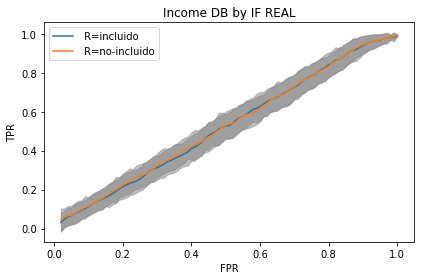

entropy
0.100000    0.507703
0.111111    0.504439
0.125000    0.503792
0.142857    0.521068
0.166667    0.528052
0.200000    0.530981
0.250000    0.530984
0.333333    0.532470
0.500000    0.549376
1.000000    0.545393
Name: auc, dtype: float64


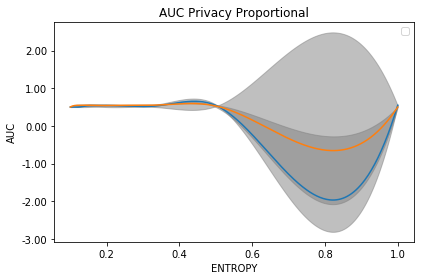

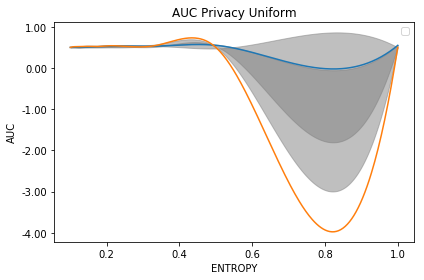

In [6]:
ds_name="income_pca"

#supervised_results = pd.concat([pn.read_csv("model_scores_roc_census06_mbe.csv"), pd.read_csv("model_scores_roc_census611_mbe.csv")])
supervised_results = pd.read_csv("model_scores_roc_"+ds_name+"20190410.csv")
rocs_by_case(supervised_results, {},{"real":["t","f"]}, savefig=True, title="by IF REAL", save_name=ds_name+"_roc_privacy_grouped_tmf",language="spanish")
#rocs_by_case(supervised_results, {"real":"m"},{"privacy":[1,2,3,4,5,7,9]}, savefig=True, title="by IF REAL", save_name=ds_name+"_roc_privacy_grouped_tmf",language="spanish")

print(supervised_results[supervised_results.real=="t"].groupby("entropy")["auc"].agg(lambda x:np.average(x)))


intersect = plot_intervals_smooth_info(supervised_results, "entropy","auc", {"uniform":[0], "uniform2":[0]}, 
               {"real":["t", "f"]}, savefig=True, 
               title="AUC Privacy Proportional", save_name=ds_name+"_auc_real_proportional")
intersection_pnt = [intersect[0][0][i]  for i in range(len(intersect[0][0])) if (abs(intersect[0][1][i]-intersect[1][1][i]) < .005)]

intersect = plot_intervals_smooth_info(supervised_results, "entropy","auc", {"uniform":[1], "uniform2":[1]}, 
               {"real":["t", "f"]}, savefig=True, 
               title="AUC Privacy Uniform", save_name=ds_name+"_auc_real_uniform")
intersection_pnt = [intersect[0][0][i]  for i in range(len(intersect[0][0])) if (abs(intersect[0][1][i]-intersect[1][1][i]) < .005)]


In [ ]:
from scipy.interpolate import BSpline

ds_meta_results = {}
for ds in [["income","011"], ["insurance","011"], ["churn","011"], ["heart","20190208"]]:
    # what info can be added from the original ds that can be compared, 
    # and have significance with the sanitized results
    # ds columns, avg categories per sanitized column, benchmark auc
    #col_vals = [np.average(list(df_eda[ds]["columns"][i]["counter"].values())) for i in list(df_eda[ds]["columns"].keys())]
    #col_vals = [len(df_eda[ds]["columns"][i]["counter"]) for i in list(df_eda[ds]["columns"].keys())]
    col_vals = [np.std(list(df_eda[ds[0]]["columns"][i]["counter"].values()))/np.average(list(df_eda[ds[0]]["columns"][i]["counter"].values())) for i in list(df_eda[ds[0]]["columns"].keys())]
    avg_cols = np.average(col_vals)
    std_cols = np.std(col_vals)
    ds_meta_results[ds[0]] = dict(meta_results(ds), **{"avg_col":avg_cols, "std_col":std_cols})

In [ ]:
result = pd.DataFrame(ds_meta_results).T

In [ ]:
print(result)

In [221]:
print(meta_results["income"]["columns"]["race"]["counter"])

TypeError: 'function' object is not subscriptable

In [ ]:
1+np.sqrt(5)/2-.5

In [222]:
from sklearn import linear_model 

In [119]:
lm = linear_model.LinearRegression()
lm.fit(result[[col for col in result.columns if col not in ["proportional","uniform"]]], result["uniform"])

/Users/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [123]:
lm.coef_

array([6.3123965 , 2.86282258, 0.13886063])

In [ ]:
!conda install pymc3

Solving environment: \ 

In [10]:
import pymc3 as pm
formula = "uniform ~ avg_col + benchmark_auc + proportional +  std_col"
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = result, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, std_col, proportional, benchmark_auc, avg_col, Intercept]
100%|██████████| 2500/2500 [02:15<00:00, 18.49it/s]
The acceptance probability does not match the target. It is 0.9979800047468689, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 407 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1cf97550>,
      dtype=object)

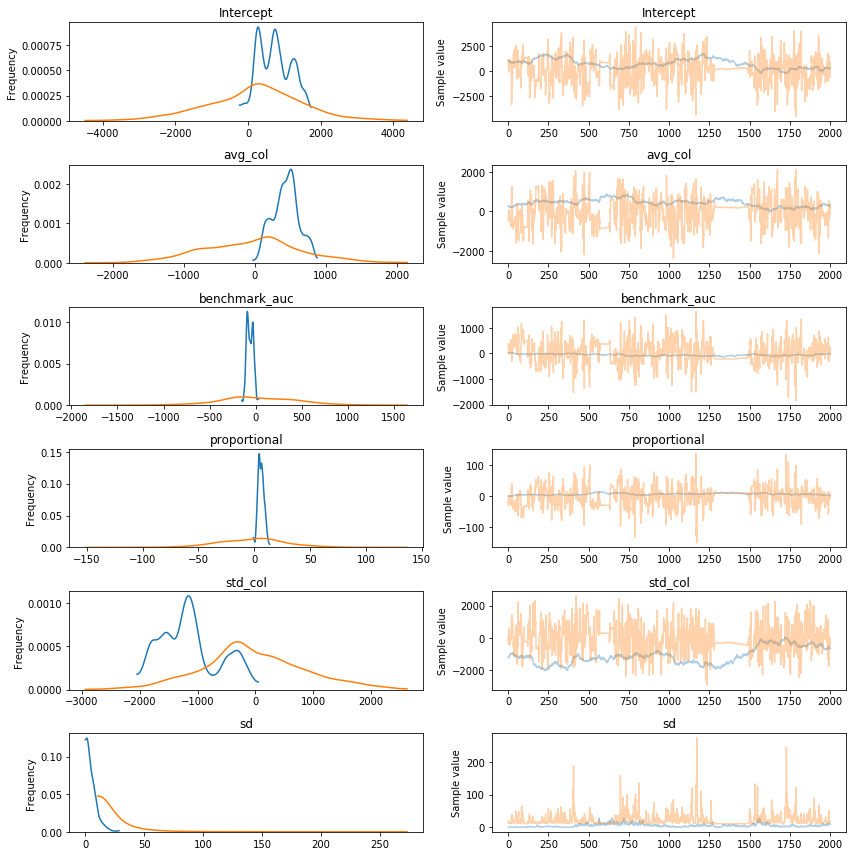

In [11]:
pm.traceplot(normal_trace)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1cf94668>,
      dtype=object)

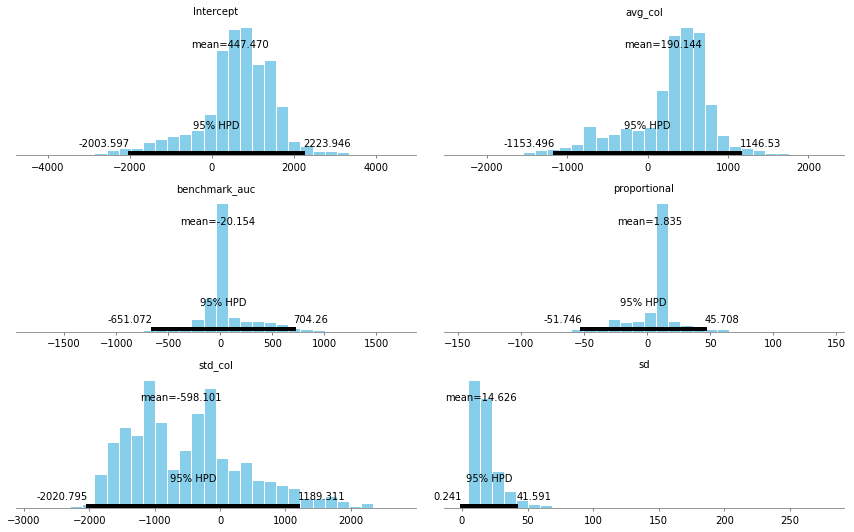

In [13]:
pm.plot_posterior(normal_trace)


In [15]:
pm.summary(normal_trace)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,447.470122,1009.316565,55.532603,-2003.597130,2223.945901,25.651436,1.085735
avg_col,190.143887,559.521852,35.589066,-1153.495809,1146.529802,4.455472,1.207888
benchmark_auc,-20.153883,306.474127,14.221270,-651.072440,704.259775,313.505735,1.018079
proportional,1.834927,21.898420,1.060747,-51.746457,45.707907,233.854396,1.037711
std_col,-598.101342,891.826309,67.753036,-2020.794946,1189.311236,2.243294,1.460937
sd,14.626315,17.054405,1.168286,0.241074,41.590904,2.706471,1.322564


In [33]:
# Examines the effect of changing a single variable
# Takes in the name of the variable, the trace, and the data
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    #steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    #plt.figure.figsize(6, 6)
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('Grade', size = 16)
    plt.title("Posterior of Grade vs %s" % query_var, size = 18)
    plt.show()

In [34]:
model_effect("benchmark_auc", normal_trace, result)

KeyError: 'uniform'